In [1]:
from functools import partial
import re

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import tensor as T

In [2]:
import os
os.environ["PYTHONOPTIMIZE"] = "1"

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# STIM_SOURCE = "random"
STIM_SOURCE = "sentences"

In [5]:
from berp.generators import stimulus
import berp.generators.thresholded_recognition_simple as gen
import berp.models.reindexing_regression as rr

In [6]:
params = rr.ModelParameters(lambda_=T(1.),
                            confusion=gen.phoneme_confusion,
                            threshold=T(0.7),
                            a=T(0.4),
                            b=T(0.1),
                            coef=T([0., -1.]),
                            sigma=T(1.0))

In [43]:
if STIM_SOURCE == "random":
    stim = stimulus.RandomStimulusGenerator()
elif STIM_SOURCE == "sentences":
    text = """
Alice was beginning to get very tired of sitting by her sister on the bank, and of having nothing to do: once or twice she had peeped into the book her sister was reading, but it had no pictures or conversations in it, `and what is the use of a book,' thought Alice `without pictures or conversation?'
So she was considering in her own mind (as well as she could, for the hot day made her feel very sleepy and stupid), whether the pleasure of making a daisy-chain would be worth the trouble of getting up and picking the daisies, when suddenly a White Rabbit with pink eyes ran close by her.
""".strip()
    sentences = [s.strip().replace("\n", "") for s in re.split(r"[.?!]", text)]
    sentences = [s for s in sentences if s]
    
    phonemes = np.array(list("abcdefghijklmnopqrstuvwxyz_"))
    stim = partial(stimulus.NaturalLanguageStimulusGenerator(phonemes=phonemes, hf_model="gpt2"), sentences)

Using pad_token, but it is not set yet.


In [44]:
ds = gen.sample_dataset(params, stim)

  0%|          | 0/1 [00:00<?, ?it/s]

tensor([ 3,  3,  9,  2,  3,  4,  5,  2,  7,  2,  3,  6,  2,  3,  4,  3,  2,  6,
         7,  3,  3, 11,  2,  3,  3,  4,  2,  4,  2,  3,  5,  3,  3,  3,  3,  4,
         3,  4])


In [45]:
ds.phoneme_onsets[:3]

tensor([[0.0000, 0.0703, 0.1217, 0.1217, 0.1217, 0.1217, 0.1217, 0.1217, 0.1217,
         0.1217, 0.1217],
        [0.0000, 0.0593, 0.1516, 0.1516, 0.1516, 0.1516, 0.1516, 0.1516, 0.1516,
         0.1516, 0.1516],
        [0.0000, 0.0609, 0.1111, 0.1725, 0.2447, 0.3229, 0.3859, 0.4424, 0.4991,
         0.4991, 0.4991]])

In [46]:
rr.predictive_model(ds.p_word, ds.candidate_phonemes, confusion=ds.params.confusion, lambda_=ds.params.lambda_)[:3]

tensor([[0.0072, 0.1536, 0.7751, 0.7751, 0.7751, 0.7751, 0.7751, 0.7751, 0.7751,
         0.7751, 0.7751],
        [0.4854, 0.9556, 0.9972, 0.9972, 0.9972, 0.9972, 0.9972, 0.9972, 0.9972,
         0.9972, 0.9972],
        [0.0110, 0.1479, 0.8600, 0.9972, 0.9999, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000]])

In [47]:
ds.word_onsets[:5]

tensor([1.0414, 1.1819, 1.4249, 1.9814, 2.1731])

torch.Size([38, 11]) torch.Size([38, 10, 11])


(0.0, 10.0)

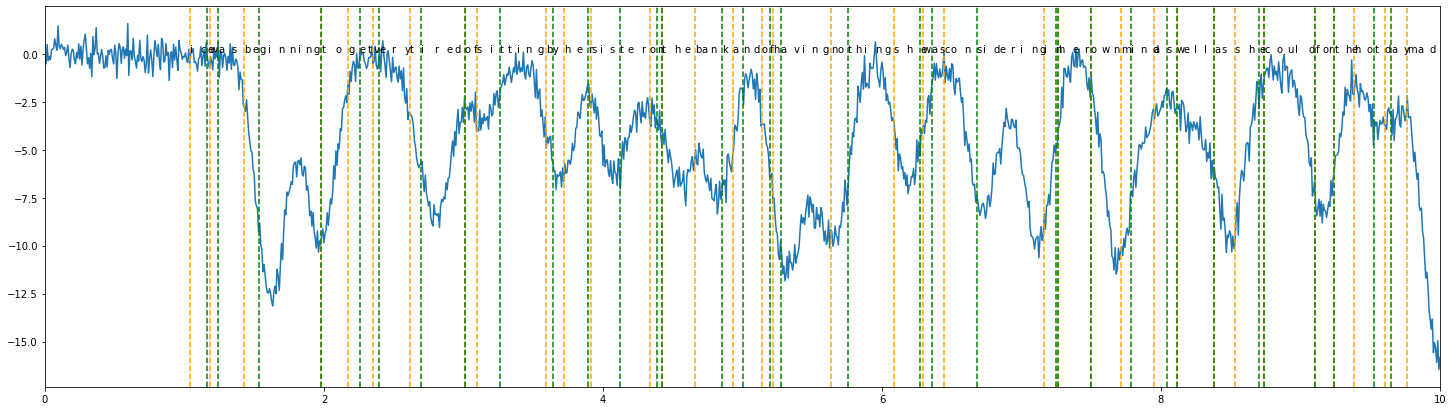

In [48]:
fig, ax = plt.subplots(figsize=(25, 7))
ax.plot(np.arange(ds.Y.shape[0]) / ds.sample_rate, ds.Y[:, 0])

for i, word_onset in enumerate(ds.word_onsets + ds.phoneme_onsets[:, 0]):
    ax.axvline(word_onset, c="orange", linestyle="--")
    for j, phoneme_onset in enumerate(word_onset + ds.phoneme_onsets[i]):
        phon = ds.phonemes[ds.candidate_phonemes[i, 0, j]]
        if phon != "_":
            ax.annotate(phon, xy=(phoneme_onset, 0.1))
for rec_onset in ds.word_onsets + ds.recognition_onsets:
    ax.axvline(rec_onset, c="green", linestyle="--")

ax.set_xlim((0, 10))

In [14]:
offsets = ((ds.recognition_onsets + ds.params.a - ds.epoch_window[0]).numpy() * ds.sample_rate).astype(int)
ds.Y_epoch[np.arange(len(ds.Y_epoch)), offsets + 3]

tensor([[ -8.2048],
        [ -4.8007],
        [-10.0513],
        [ -0.5875],
        [ -3.1512],
        [ -6.1558],
        [ -3.5078],
        [ -0.3241],
        [ -6.3361],
        [ -6.1899],
        [ -3.1598],
        [ -6.1846],
        [ -6.5117],
        [ -0.0521],
        [ -9.3370],
        [ -3.1406],
        [ -7.2583],
        [ -1.6016],
        [ -6.1221],
        [ -6.0782],
        [ -1.9846],
        [ -9.5617],
        [ -8.3851],
        [ -2.1017],
        [ -2.9142],
        [ -3.2622],
        [ -7.6615],
        [ -2.8730],
        [ -0.5324],
        [ -4.7420],
        [ -2.4049],
        [ -3.7643],
        [ -1.5610],
        [-12.5173],
        [ -4.9973],
        [-12.0063],
        [ -1.0412],
        [ -1.7124]])

In [15]:
ds.p_word[:, 0]

tensor([-6.3512, -2.9601, -6.7436, -0.0531, -2.5049, -4.3956, -2.3825, -0.4309,
        -4.4610, -4.2756, -1.5525, -4.4010, -4.8019, -0.3425, -6.6442, -2.7124,
        -5.2548, -1.6657, -4.6861, -4.5865, -1.4261, -6.9641, -5.7334, -1.7267,
        -1.9283, -2.4581, -5.3399, -1.5852, -0.4630, -3.8239, -2.1007, -2.2403,
        -1.1018, -8.8537, -3.3988, -9.2546, -0.5486, -1.0338])

In [16]:
ds.X_epoch

tensor([[ 1.0000,  9.1629],
        [ 1.0000,  4.2705],
        [ 1.0000,  9.7290],
        [ 1.0000,  0.0766],
        [ 1.0000,  3.6138],
        [ 1.0000,  6.3415],
        [ 1.0000,  3.4372],
        [ 1.0000,  0.6217],
        [ 1.0000,  6.4359],
        [ 1.0000,  6.1683],
        [ 1.0000,  2.2398],
        [ 1.0000,  6.3493],
        [ 1.0000,  6.9277],
        [ 1.0000,  0.4941],
        [ 1.0000,  9.5855],
        [ 1.0000,  3.9131],
        [ 1.0000,  7.5811],
        [ 1.0000,  2.4031],
        [ 1.0000,  6.7607],
        [ 1.0000,  6.6169],
        [ 1.0000,  2.0575],
        [ 1.0000, 10.0471],
        [ 1.0000,  8.2716],
        [ 1.0000,  2.4911],
        [ 1.0000,  2.7820],
        [ 1.0000,  3.5463],
        [ 1.0000,  7.7039],
        [ 1.0000,  2.2869],
        [ 1.0000,  0.6679],
        [ 1.0000,  5.5168],
        [ 1.0000,  3.0307],
        [ 1.0000,  3.2321],
        [ 1.0000,  1.5896],
        [ 1.0000, 12.7732],
        [ 1.0000,  4.9035],
        [ 1.0000, 13